# Decision trees

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

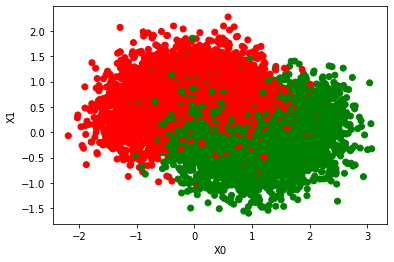

In [3]:
X, y = make_moons(n_samples = 10000, noise = 0.4)

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

def map_color(array):
    colors = ['red', 'green', 'blue']
    return [colors[i] for i in array]

def display_moons(X, y):
    x_axis = X[:, 0]
    y_axis = X[:, 1]
    plt.figure()
    plt.scatter(x_axis, y_axis, color=map_color(y))
    plt.xlabel('X0')
    plt.ylabel('X1')

display_moons(X, y)

In [4]:
# Essayons de fit un simple arbre de décision

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
decision_tree = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None)

def decision_tree_fit_info(decision_tree):
    decision_tree.fit(X, y)
    print(f"Profondeur: {decision_tree.get_depth()}")
    print(f"Nb Leaves: {decision_tree.get_n_leaves()}")
    print(f"Précision: {decision_tree.score(X, y)}")
    print("On voit qu'il y a over-fitting")

    print("Precision lors d'une 5-cross-validation:")
    print(cross_val_score(decision_tree, X, y, cv=5))
    print(f"Score sur le jeu de test: {decision_tree.score(X_test, y_test)}")

decision_tree_fit_info(decision_tree)

Profondeur: 30
Nb Leaves: 1286
Précision: 1.0
On voit qu'il y a over-fitting
Precision lors d'une 5-cross-validation:
[0.80324797 0.803125   0.78875    0.800625   0.79799875]
Score sur le jeu de test: 0.776


In [8]:
# Recherche des meilleurs paramètres par quadrillage
from sklearn.model_selection import GridSearchCV

params_grid = [
    {
        "max_depth": [10, 100, None],
        "max_leaf_nodes": [10, 100, 1000, 10000],
        "min_samples_leaf": [1, 10, 100, 1000], 
        "min_samples_split" : [2, 10, 100],
    }
]
searching_tree = DecisionTreeClassifier()
search = GridSearchCV(searching_tree, cv=5, param_grid=params_grid, refit=True)
search.fit(X, y)
print(f"Best params : {search.best_params_}")
print(f"Best score : {search.best_score_}")
print(f"Score sur le jeu de test:{search.score(X_test, y_test)}")
# On voit qu'avec notre recherche par quadrillage, nous avons empêché le sur-ajustement, et en régularisant, nous avons certes introduit un biais, mais nous avons réduit la variance, et on voit que nous avons un meilleur résultat sur le jeu de validation

Best params : {'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score : 0.852
Score sur le jeu de test:0.857


In [7]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_score

n_trees = 1000
shuffler = ShuffleSplit(n_splits=n_trees, train_size=100)
all_index_list_for_bagging = []
for train_index, test_index in shuffler.split(X):
    all_index_list_for_bagging.append(train_index)

my_trees_list = []
for i in range(n_trees):
    arbre = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2)
    X_indexes = all_index_list_for_bagging[i]
    subX = X[X_indexes]
    subY = y[X_indexes]
    arbre.fit(subX, subY)
    my_trees_list.append(arbre)

print(f"Score moyen des 1000 arbres:{np.mean([tree.score(X_test, y_test) for tree in my_trees_list])}")

def predict_majoritaire(X, y):
    all_predictions = [tree.predict(X_test) for tree in my_trees_list]
    # Each row is the whole predicted set for one tree
    vote_majoritaire = mode(all_predictions)[0][0]
    precision = precision_score(y, vote_majoritaire)

    return vote_majoritaire, precision

_, precision_majoritaire = predict_majoritaire(X_test, y_test)
print(f"Précision par vote majoritaire: {precision_majoritaire}")

# Nous voyons qu'individuellement, les modèles sont moins bons, mais que par vote majoritaire, ils deviennent meilleurs que lorsqu'on a un seul bon prédicteur


Score moyen des 1000 arbres:0.8098695
[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
Précision par vote majoritaire: 0.8697001034126164


In [44]:
# Au lieu de faire un simple vote majoritaire, on fait la moyenne des proba prédites. Ici on voit que les résultats sont semblables
def predict_majoritaire_proba(X, y):
    all_predictions = [tree.predict_proba(X_test) for tree in my_trees_list]
    # Each row is the whole predicted set for one tree

    # all_prediction est un array dont: l' axe 0 donne les prédictions de chaque régresseur, et l'axe 1 donne la proba prédite pour chaque classe.
    # Pour chaque classe, on veut faire la moyenne des proba prédites sur tous les régresseurs, donc une moyenne sur axis=0
    mean_proba = np.mean(all_predictions, axis = 0) 

    # mean_proba est un array de taille n x 2. On veut, pour chaque ligne, savoir quelle colonne a la plus grande valeur
    vote_majoritaire = np.argmax(mean_proba, axis = 1)
    precision = precision_score(y, vote_majoritaire)

    return vote_majoritaire, precision

_, precision_majoritaire_proba = predict_majoritaire_proba(X_test, y_test)
print(f"Précision par moyenne des proba prédites: {precision_majoritaire_proba}")


Précision par moyenne des proba prédites: 0.868937048503612
